<a href="https://colab.research.google.com/github/Nouhailachakouk/Our-Predicto/blob/main/understandambient_temperature_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Load data
df = pd.read_csv('/content/ambient_temperature_system_failure.csv', parse_dates=['timestamp'], index_col='timestamp')

In [ ]:
# Check frequency of missing data (updated to 'h' for hours)
missing_hours = pd.date_range(
    start=df.index.min(),
    end=df.index.max(),
    freq='h'  # Use 'h' instead of deprecated 'H'
).difference(df.index)

print(f"Missing hours: {len(missing_hours)}")
print(f"Example missing timestamps:\n{missing_hours[:5]}")  # Inspect first 5 gaps

Missing hours: 621
Example missing timestamps:
DatetimeIndex(['2013-07-28 02:00:00', '2013-07-28 05:00:00',
               '2013-07-28 06:00:00', '2013-07-28 07:00:00',
               '2013-07-28 08:00:00'],
              dtype='datetime64[ns]', freq=None)


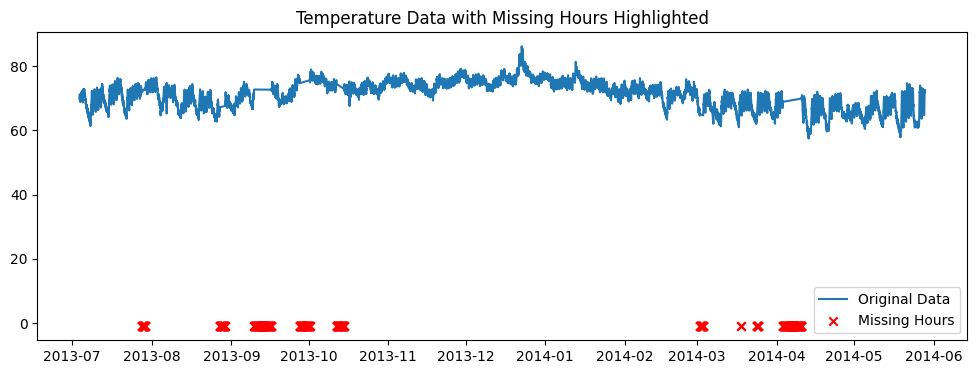

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['value'], label='Original Data')
plt.scatter(missing_hours, [-1]*len(missing_hours), color='red', marker='x', label='Missing Hours')
plt.legend()
plt.title('Temperature Data with Missing Hours Highlighted')
plt.show()

In [ ]:
# Forward-fill small gaps (<6 hours) and interpolate the rest
df_filled = df.resample('h').asfreq()  # Force hourly frequency (creates NaNs)
df_filled['value'] = df_filled['value'].interpolate(
    method='time',  # Accounts for timestamp spacing
    limit=6         # Max 6 consecutive missing values to interpolate
)

# Optional: Mark interpolated values for transparency
df_filled['is_interpolated'] = df_filled['value'].isna().astype(int)

In [ ]:
# Flag long gaps (>24 hours) without interpolation
gap_threshold = 24
df_filled['gap_size'] = df_filled['value'].isna().astype(int).groupby(~df_filled['value'].isna()).cumsum()
df_filled['is_long_gap'] = (df_filled['gap_size'] > gap_threshold).astype(int)

In [ ]:
df_minutely = df_filled.resample('T').interpolate(method='pchip')  # Smooth curve

<ipython-input-6-06d48e364ff2>:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_minutely = df_filled.resample('T').interpolate(method='pchip')  # Smooth curve


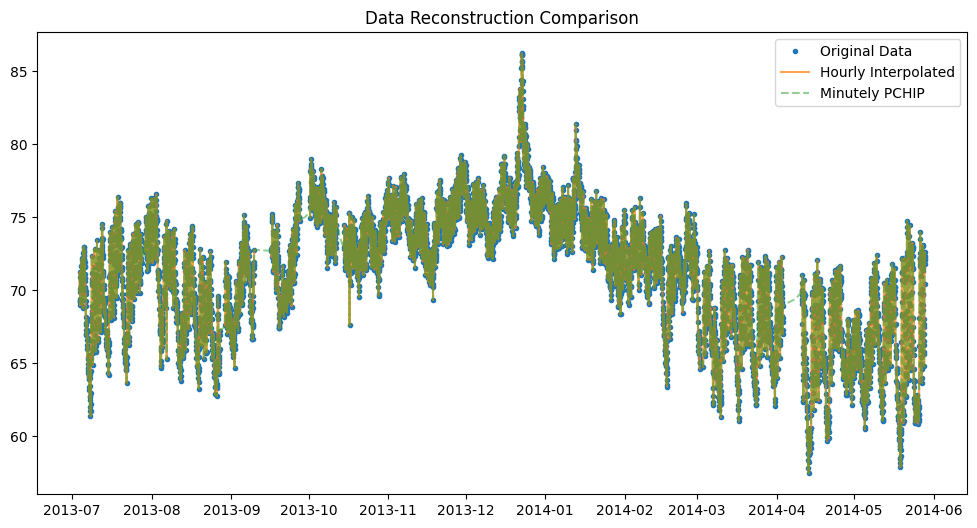

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['value'], 'o', label='Original Data', markersize=3)
plt.plot(df_filled.index, df_filled['value'], '-', label='Hourly Interpolated', alpha=0.7)
plt.plot(df_minutely.index, df_minutely['value'], '--', label='Minutely PCHIP', alpha=0.5)
plt.legend()
plt.title('Data Reconstruction Comparison')
plt.show()

In [ ]:
# Identify the largest gap period
gap_periods = df_filled[df_filled['is_long_gap'] == 1]
gap_start = gap_periods.index[0]
gap_end = gap_periods.index[-1]

print(f"Major system downtime from {gap_start} to {gap_end}")

Major system downtime from 2013-07-29 11:00:00 to 2014-04-10 14:00:00


In [ ]:
# Method A: Statistical bounds (e.g., μ ± 3σ)
mean = df_filled['value'].mean()
std = df_filled['value'].std()
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std


In [ ]:
# Copy the original series
df_filled['value_truncated'] = df_filled['value']

# Truncate outliers
df_filled['value_truncated'] = df_filled['value_truncated'].clip(
    lower=lower_bound,
    upper=upper_bound
)

# Optional: Flag truncated points
df_filled['is_truncated'] = (
    (df_filled['value'] < lower_bound) |
    (df_filled['value'] > upper_bound)
).astype(int)

Points truncated: 19


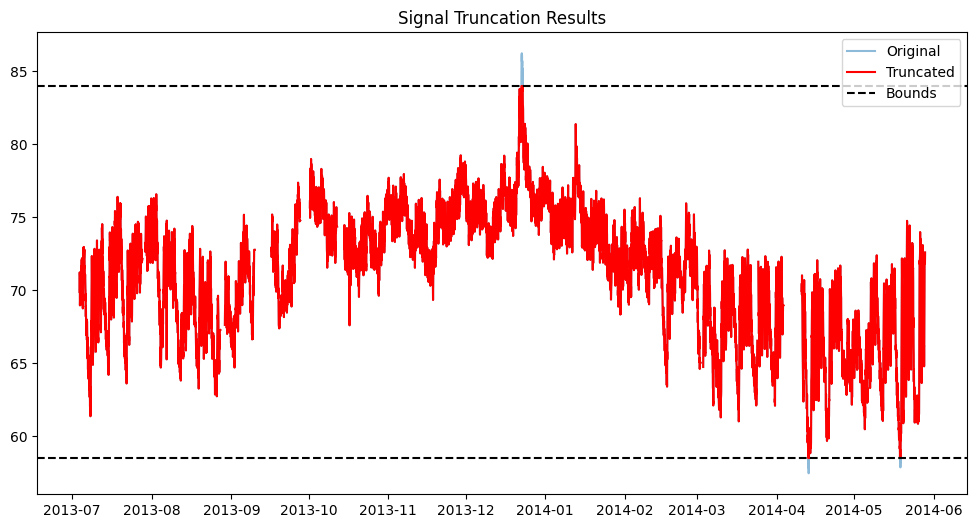

In [ ]:
print(f"Points truncated: {df_filled['is_truncated'].sum()}")
plt.figure(figsize=(12,6))
plt.plot(df_filled.index, df_filled['value'], label='Original', alpha=0.5)
plt.plot(df_filled.index, df_filled['value_truncated'], label='Truncated', color='red')
plt.axhline(y=upper_bound, color='k', linestyle='--', label='Bounds')
plt.axhline(y=lower_bound, color='k', linestyle='--')
plt.legend()
plt.title("Signal Truncation Results")
plt.show()

In [ ]:
import numpy as np
weights = np.array([0.1, 0.2, 0.3, 0.4])  # Custom weights (sum=1)
df_filled['wma'] = df_filled['value_truncated'].rolling(
    window=len(weights)
).apply(lambda x: np.dot(x, weights))

In [ ]:
# First, verify your DataFrame structure
print("Existing columns:", df_filled.columns.tolist())

# Check if 'value_truncated' exists (required for EMA calculation)
if 'value_truncated' not in df_filled.columns:
    print("Error: 'value_truncated' column missing!")
    # Recreate it if necessary:
    df_filled['value_truncated'] = df_filled['value'].clip(lower_bound, upper_bound)

# Now properly calculate EMA
try:
    span = 12  # 12-hour half-life
    df_filled['ema'] = df_filled['value_truncated'].ewm(
        span=span,
        adjust=False,
        min_periods=1  # Ensure it works with partial windows
    ).mean()
    print("EMA calculation successful!")
except Exception as e:
    print(f"Error calculating EMA: {str(e)}")

Existing columns: ['value', 'is_interpolated', 'gap_size', 'is_long_gap', 'value_truncated', 'is_truncated', 'wma']
EMA calculation successful!


                     value_truncated        sma        ema        wma
timestamp                                                            
2013-07-04 00:00:00        69.880835  69.880835  69.880835        NaN
2013-07-04 01:00:00        71.220227  70.550531  70.086895        NaN
2013-07-04 02:00:00        70.877805  70.659622  70.208574        NaN
2013-07-04 03:00:00        68.959400  70.234567  70.016393  70.079230
2013-07-04 04:00:00        69.283551  70.085246  69.903648  69.698824


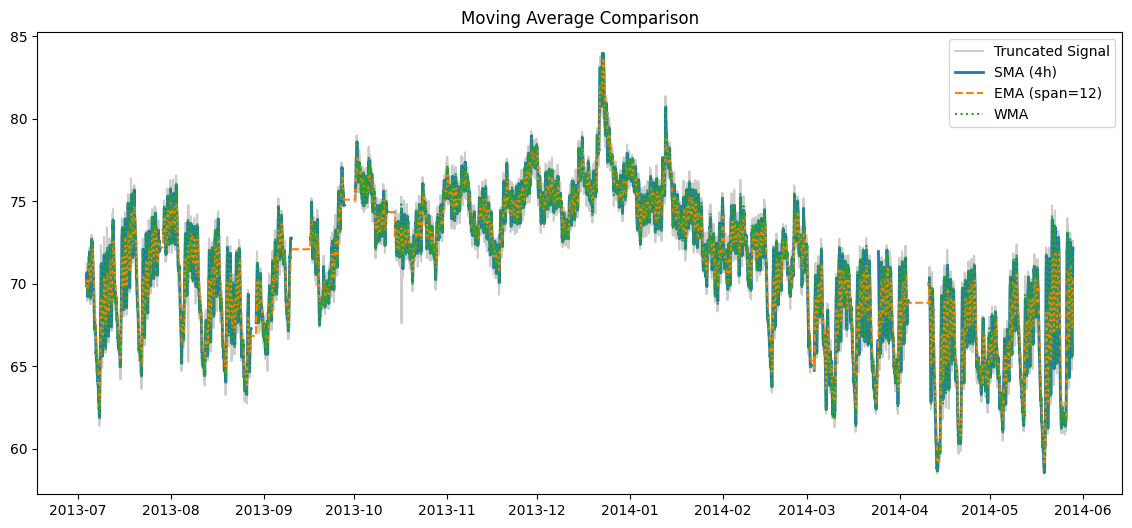

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Ensure we have the required columns
if 'value_truncated' not in df_filled.columns:
    # Calculate bounds (example - adjust to your needs)
    lower_bound = df_filled['value'].quantile(0.01)
    upper_bound = df_filled['value'].quantile(0.99)
    df_filled['value_truncated'] = df_filled['value'].clip(lower_bound, upper_bound)

# 2. Calculate all moving averages
window_size = 4  # hours
weights = np.array([0.1, 0.2, 0.3, 0.4])  # For WMA

df_filled['sma'] = df_filled['value_truncated'].rolling(
    window=window_size,
    min_periods=1
).mean()

df_filled['ema'] = df_filled['value_truncated'].ewm(
    span=12,
    adjust=False,
    min_periods=1
).mean()

df_filled['wma'] = df_filled['value_truncated'].rolling(
    window=len(weights)
).apply(lambda x: np.dot(x, weights))

# 3. Verify calculations
print(df_filled[['value_truncated', 'sma', 'ema', 'wma']].head())

# 4. Visualization
plt.figure(figsize=(14,6))
plt.plot(df_filled.index, df_filled['value_truncated'],
         label='Truncated Signal', alpha=0.4, color='gray')
plt.plot(df_filled.index, df_filled['sma'],
         label=f'SMA ({window_size}h)', linewidth=2)
plt.plot(df_filled.index, df_filled['ema'],
         label='EMA (span=12)', linestyle='--')
plt.plot(df_filled.index, df_filled['wma'],
         label='WMA', linestyle=':')
plt.legend()
plt.title("Moving Average Comparison")
plt.show()

In [ ]:
print("Current columns:", df.columns.tolist())

Current columns: ['value']


In [ ]:
# Calculate bounds (adjust percentiles as needed)
lower_bound = df['value'].quantile(0.01)  # 1st percentile
upper_bound = df['value'].quantile(0.99)  # 99th percentile

# Create truncated column
df['value_truncated'] = df['value'].clip(lower_bound, upper_bound)

In [ ]:
from scipy.signal import butter, filtfilt

def lowpass_filter(data, cutoff=0.02, fs=1.0, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Apply filter
df['value_lowpass'] = lowpass_filter(df['value_truncated'])

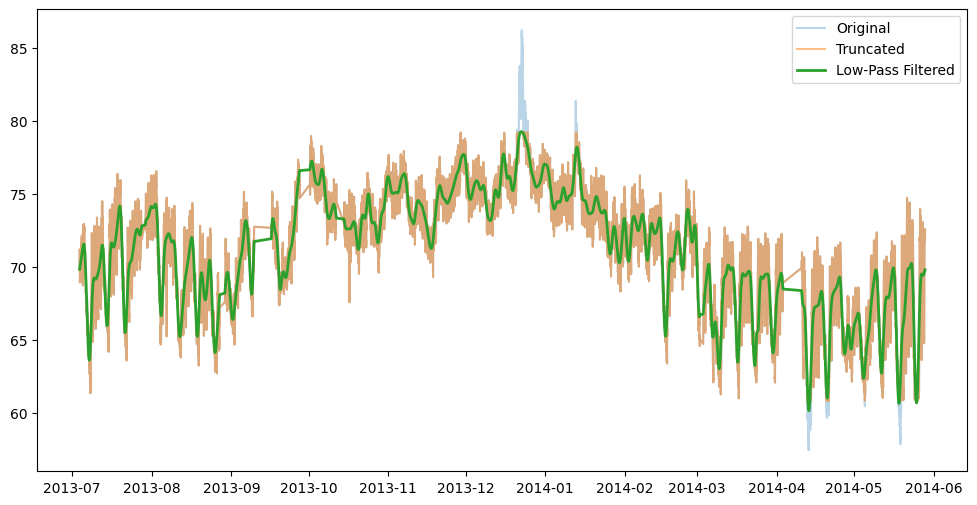

In [ ]:
# 4. Visualize
plt.figure(figsize=(12,6))
plt.plot(df.index, df['value'], label='Original', alpha=0.3)
plt.plot(df.index, df['value_truncated'], label='Truncated', alpha=0.5)
plt.plot(df.index, df['value_lowpass'], label='Low-Pass Filtered', linewidth=2)
plt.legend()
plt.show()

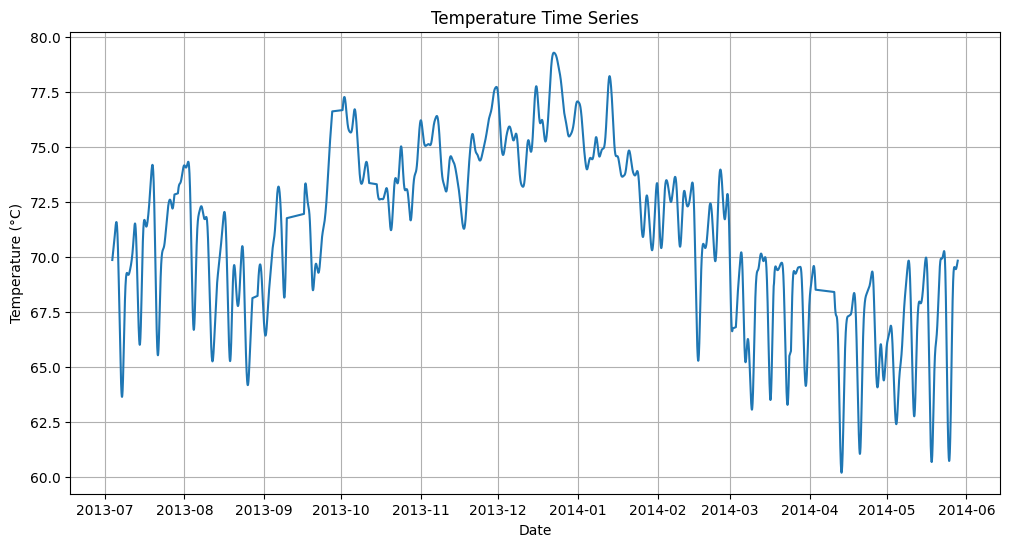

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your data is loaded as df with a datetime index
plt.figure(figsize=(12,6))
plt.plot(df.index, df['value_lowpass'], label='Filtered Temperature')
plt.title('Temperature Time Series')
plt.ylabel('Temperature (°C)')
plt.xlabel('Date')
plt.grid()
plt.show()

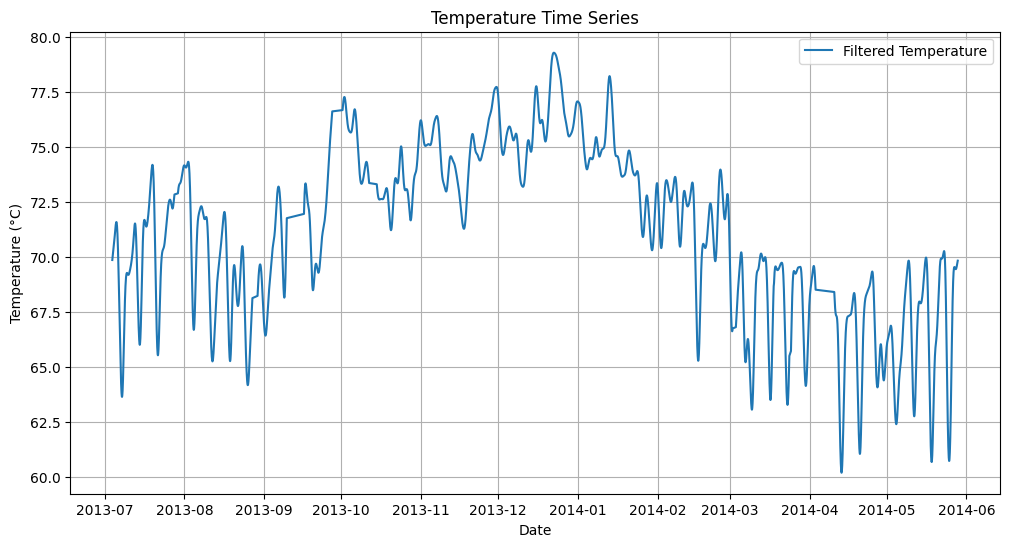

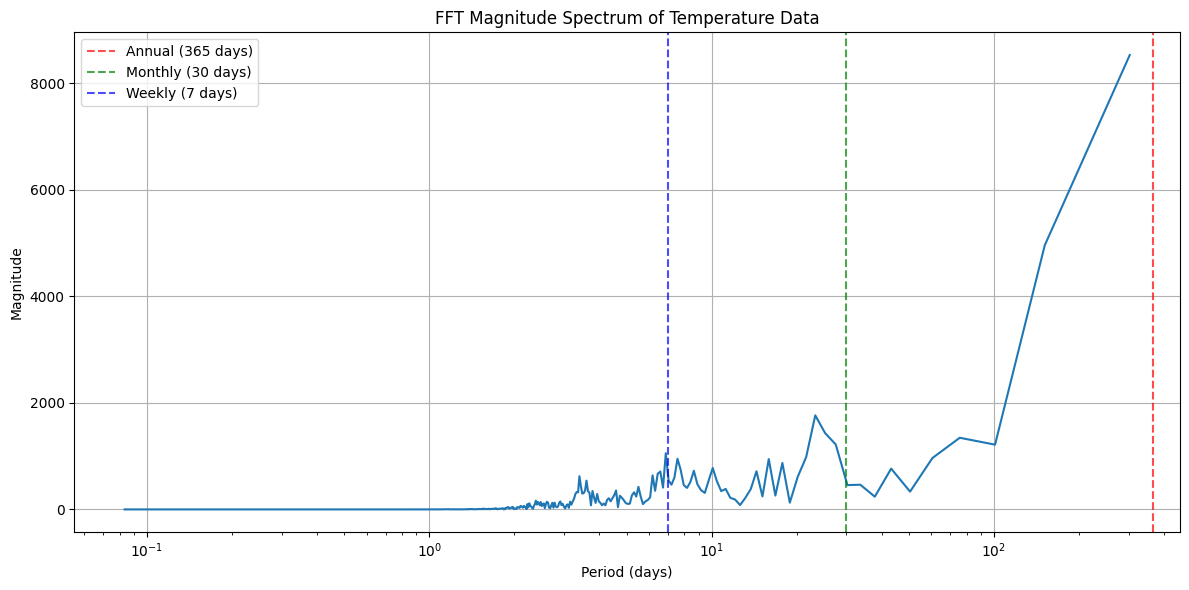


Dominant periods in the temperature time series:
1. Period: 302.79 days, Magnitude: 8526.47
2. Period: 151.40 days, Magnitude: 4956.13
3. Period: 23.29 days, Magnitude: 1764.93
4. Period: 25.23 days, Magnitude: 1432.43
5. Period: 75.70 days, Magnitude: 1344.59


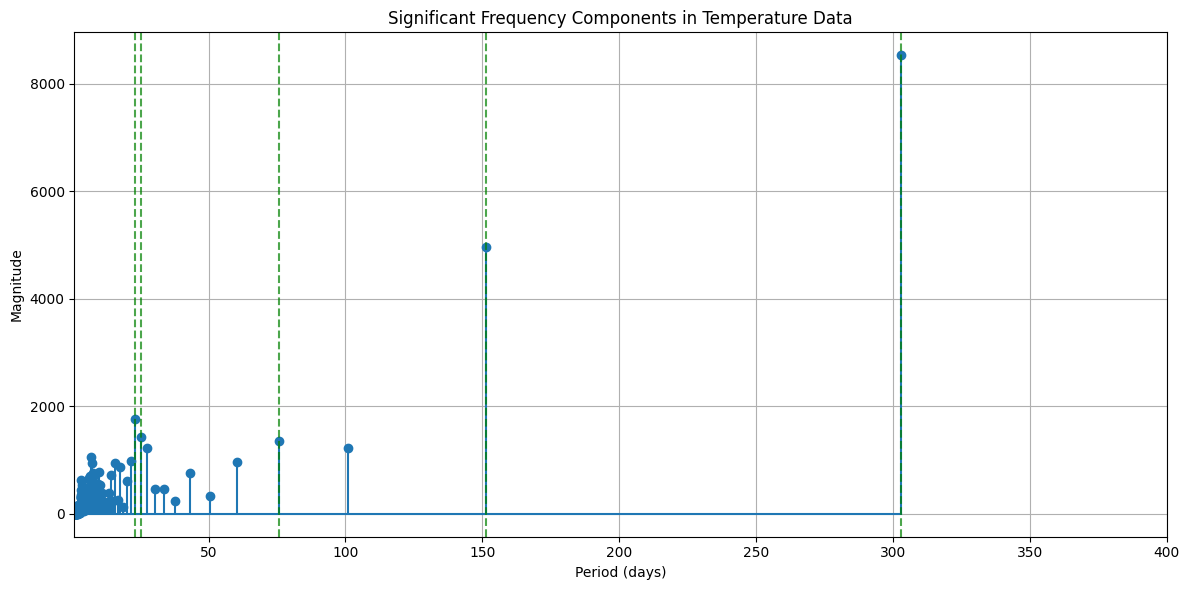

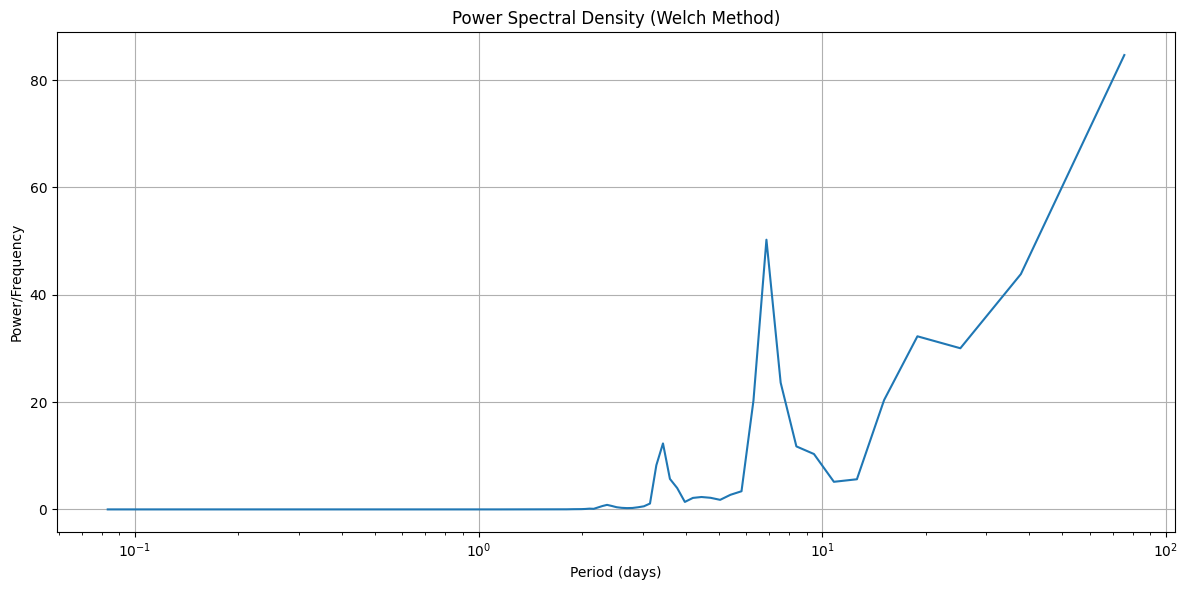

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

# Assuming your data is loaded as df with a datetime index
plt.figure(figsize=(12,6))
plt.plot(df.index, df['value_lowpass'], label='Filtered Temperature')
plt.title('Temperature Time Series')
plt.ylabel('Temperature (°C)')
plt.xlabel('Date')
plt.grid()
plt.legend()
plt.show()

# Now let's perform FFT analysis on the filtered data
# Extract the temperature values
temp_values = df['value_lowpass'].values

# Calculate sampling frequency
# Assuming data is regularly sampled
time_diff = df.index.to_series().diff().median().total_seconds()
fs = 1 / (time_diff / 86400)  # Convert to samples per day

# Detrend the data (remove mean)
temp_detrended = temp_values - np.mean(temp_values)

# Apply a window function to reduce spectral leakage
window = signal.windows.hann(len(temp_detrended))
temp_windowed = temp_detrended * window

# Perform FFT
fft_result = np.fft.rfft(temp_windowed)
fft_magnitude = np.abs(fft_result)

# Calculate frequencies
freq = np.fft.rfftfreq(len(temp_windowed), d=1/fs)

# Convert to periods (in days)
periods = 1/freq[1:]  # Skip DC component (0 Hz)
magnitude = fft_magnitude[1:]  # Skip DC component

# Plot FFT magnitude spectrum
plt.figure(figsize=(12, 6))
plt.plot(periods, magnitude)
plt.xscale('log')  # Log scale for better visualization
plt.grid(True)
plt.title('FFT Magnitude Spectrum of Temperature Data')
plt.xlabel('Period (days)')
plt.ylabel('Magnitude')

# Add reference lines for common periods
plt.axvline(x=365, color='r', linestyle='--', alpha=0.7, label='Annual (365 days)')
plt.axvline(x=30, color='g', linestyle='--', alpha=0.7, label='Monthly (30 days)')
plt.axvline(x=7, color='b', linestyle='--', alpha=0.7, label='Weekly (7 days)')
plt.legend()
plt.tight_layout()
plt.show()

# Find the dominant periods
# Sort periods by magnitude
sorted_indices = np.argsort(magnitude)[::-1]  # Descending order
top_n = 5  # Number of top periods to identify
top_indices = sorted_indices[:top_n]
top_periods = periods[top_indices]
top_magnitudes = magnitude[top_indices]

print("\nDominant periods in the temperature time series:")
for i, (period, mag) in enumerate(zip(top_periods, top_magnitudes), 1):
    print(f"{i}. Period: {period:.2f} days, Magnitude: {mag:.2f}")

# Plot with stem to highlight the peaks
plt.figure(figsize=(12, 6))
plt.stem(periods, magnitude, basefmt='-')  # Remove the use_line_collection parameter
plt.grid(True)
plt.title('Significant Frequency Components in Temperature Data')
plt.xlabel('Period (days)')
plt.ylabel('Magnitude')
plt.xlim(1, 400)  # Focus on periods between 1 day and ~1 year

# Highlight top periods
for period in top_periods:
    if 1 < period < 400:
        plt.axvline(x=period, color='green', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Optional: Power Spectral Density analysis using Welch's method
f, Pxx = signal.welch(temp_detrended, fs=fs, nperseg=len(temp_detrended)//4)
periods_welch = 1/f[1:]  # Skip DC component
psd = Pxx[1:]  # Skip DC component

plt.figure(figsize=(12, 6))
plt.plot(periods_welch, psd)
plt.grid(True)
plt.xscale('log')
plt.title('Power Spectral Density (Welch Method)')
plt.xlabel('Period (days)')
plt.ylabel('Power/Frequency')
plt.tight_layout()
plt.show()

Potential fundamental period: 302.79 days
Fundamental frequency (1x): 0.003303 cycles/day

Harmonic Analysis:
------------------
1x (Fundamental): 302.79 days, Magnitude: 8526.47
2x: 151.40 days, Magnitude: 4956.13
3x: 100.93 days, Magnitude: 1214.89
4x: 75.70 days, Magnitude: 1344.59
5x: 60.56 days, Magnitude: 964.33
6x: 50.47 days, Magnitude: 333.54
7x: 43.26 days, Magnitude: 765.24
8x: 37.85 days, Magnitude: 239.02
9x: 33.64 days, Magnitude: 463.00
10x: 27.53 days, Magnitude: 1218.79


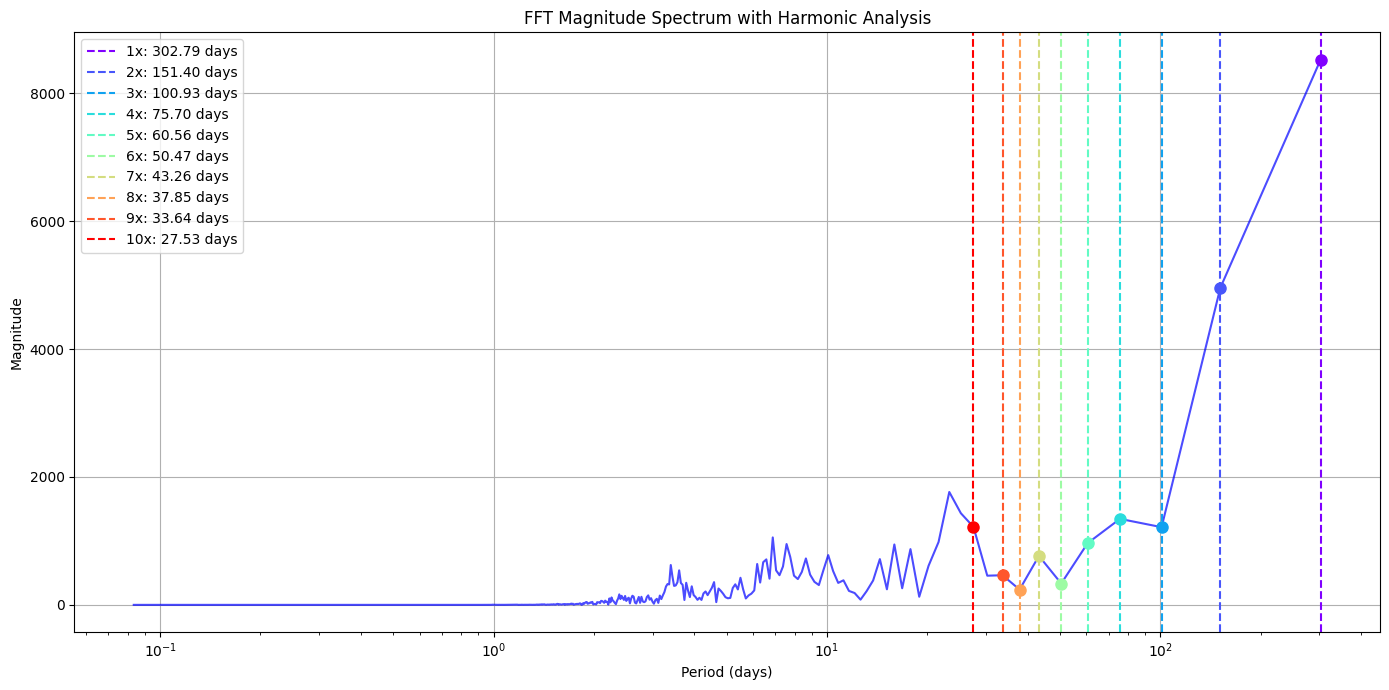

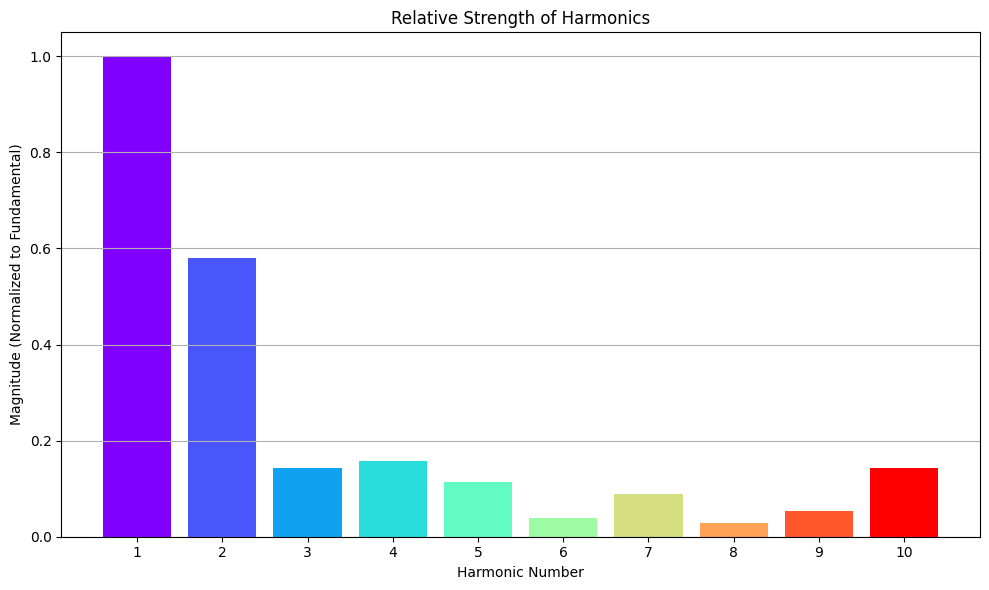

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

# Assuming the FFT analysis has already been performed
# and you have 'periods' and 'magnitude' arrays

# Find potential fundamental frequency (the one with highest magnitude)
fundamental_idx = np.argmax(magnitude)
fundamental_period = periods[fundamental_idx]
fundamental_freq = 1/fundamental_period  # Convert period to frequency

print(f"Potential fundamental period: {fundamental_period:.2f} days")
print(f"Fundamental frequency (1x): {fundamental_freq:.6f} cycles/day")

# Check for harmonic relationships
# Harmonics would be integer multiples of the fundamental frequency
# Or equivalently, fractions of the fundamental period
max_harmonic = 10  # Check up to 10th harmonic
harmonics = []

for harmonic_number in range(1, max_harmonic + 1):
    harmonic_freq = fundamental_freq * harmonic_number
    harmonic_period = 1 / harmonic_freq

    # Look for peaks near expected harmonic frequencies
    # Allow some tolerance in the identification
    tolerance = 0.1  # 10% tolerance
    expected_period_min = harmonic_period * (1 - tolerance)
    expected_period_max = harmonic_period * (1 + tolerance)

    # Find peaks in the expected range
    harmonic_candidates = []
    for i, p in enumerate(periods):
        if expected_period_min <= p <= expected_period_max:
            harmonic_candidates.append((i, p, magnitude[i]))

    # Select the highest peak in the expected range, if any
    if harmonic_candidates:
        best_match = max(harmonic_candidates, key=lambda x: x[2])
        idx, period, mag = best_match
        harmonics.append({
            'harmonic': harmonic_number,
            'expected_period': harmonic_period,
            'actual_period': period,
            'freq': 1/period,
            'magnitude': mag,
            'idx': idx
        })

# Print harmonic information
print("\nHarmonic Analysis:")
print("------------------")
for h in harmonics:
    if h['harmonic'] == 1:
        print(f"1x (Fundamental): {h['actual_period']:.2f} days, Magnitude: {h['magnitude']:.2f}")
    else:
        print(f"{h['harmonic']}x: {h['actual_period']:.2f} days, Magnitude: {h['magnitude']:.2f}")

# Plot the spectrum with harmonics highlighted
plt.figure(figsize=(14, 7))
plt.plot(periods, magnitude, 'b-', alpha=0.7)
plt.grid(True)
plt.title('FFT Magnitude Spectrum with Harmonic Analysis')
plt.xlabel('Period (days)')
plt.ylabel('Magnitude')
plt.xscale('log')  # Log scale for better visualization

# Highlight harmonics
colors = plt.cm.rainbow(np.linspace(0, 1, len(harmonics)))
for i, h in enumerate(harmonics):
    plt.axvline(x=h['actual_period'], color=colors[i], linestyle='--',
                label=f"{h['harmonic']}x: {h['actual_period']:.2f} days")
    plt.plot(h['actual_period'], h['magnitude'], 'o', color=colors[i], markersize=8)

plt.legend()
plt.tight_layout()
plt.show()

# Create a bar chart showing the relative strength of harmonics
plt.figure(figsize=(10, 6))
harmonic_numbers = [h['harmonic'] for h in harmonics]
harmonic_magnitudes = [h['magnitude'] for h in harmonics]

# Normalize magnitudes relative to fundamental
normalized_magnitudes = [m / harmonic_magnitudes[0] for m in harmonic_magnitudes]

plt.bar(harmonic_numbers, normalized_magnitudes, color=colors)
plt.grid(True, axis='y')
plt.title('Relative Strength of Harmonics')
plt.xlabel('Harmonic Number')
plt.ylabel('Magnitude (Normalized to Fundamental)')
plt.xticks(harmonic_numbers)
plt.tight_layout()
plt.show()

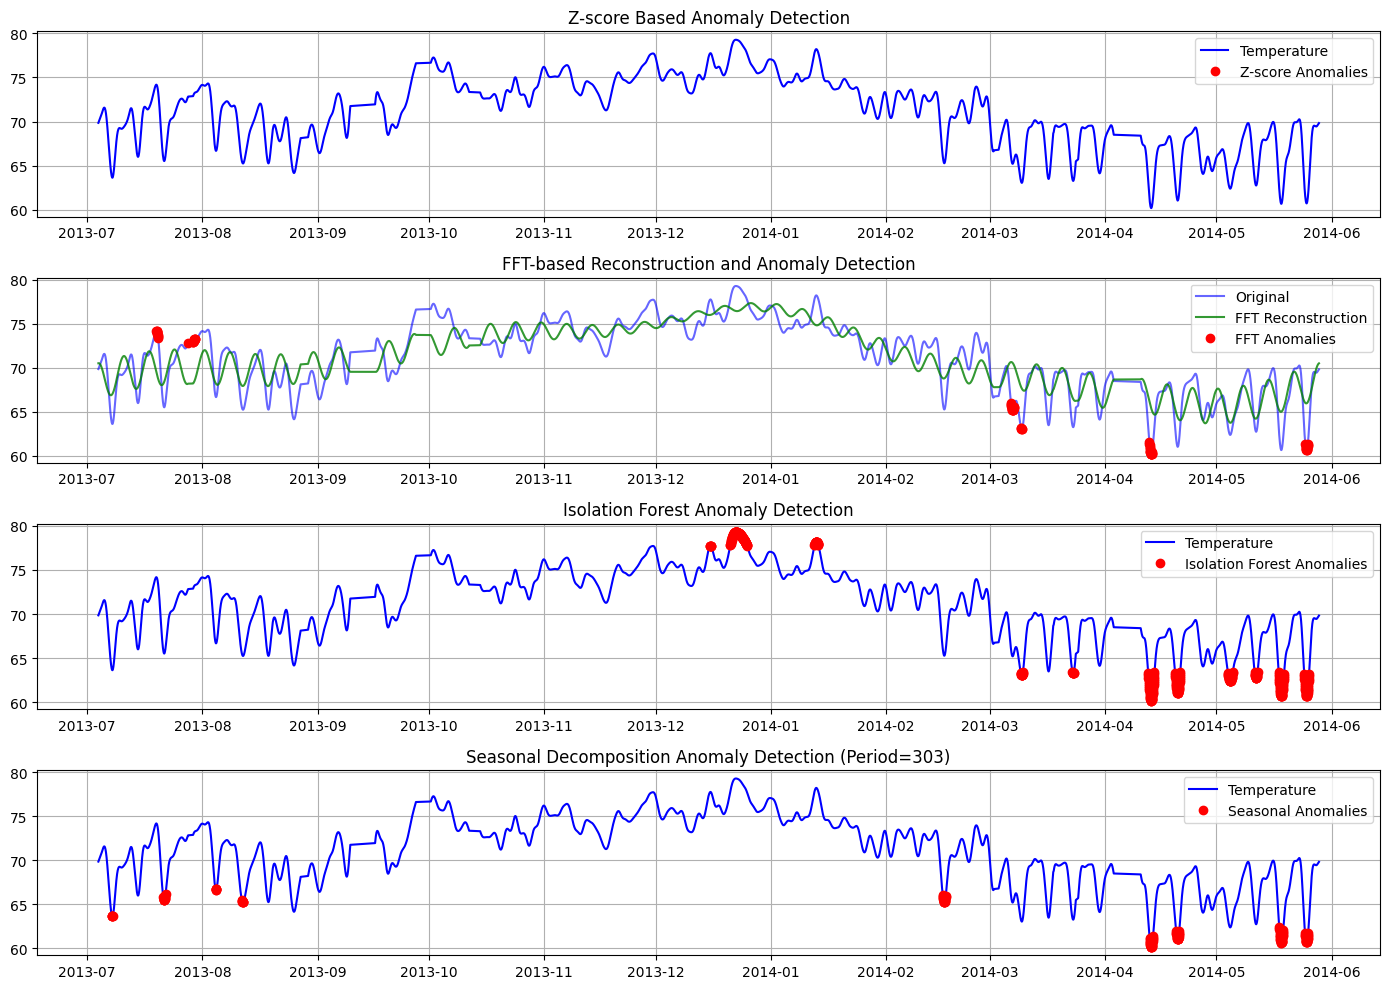

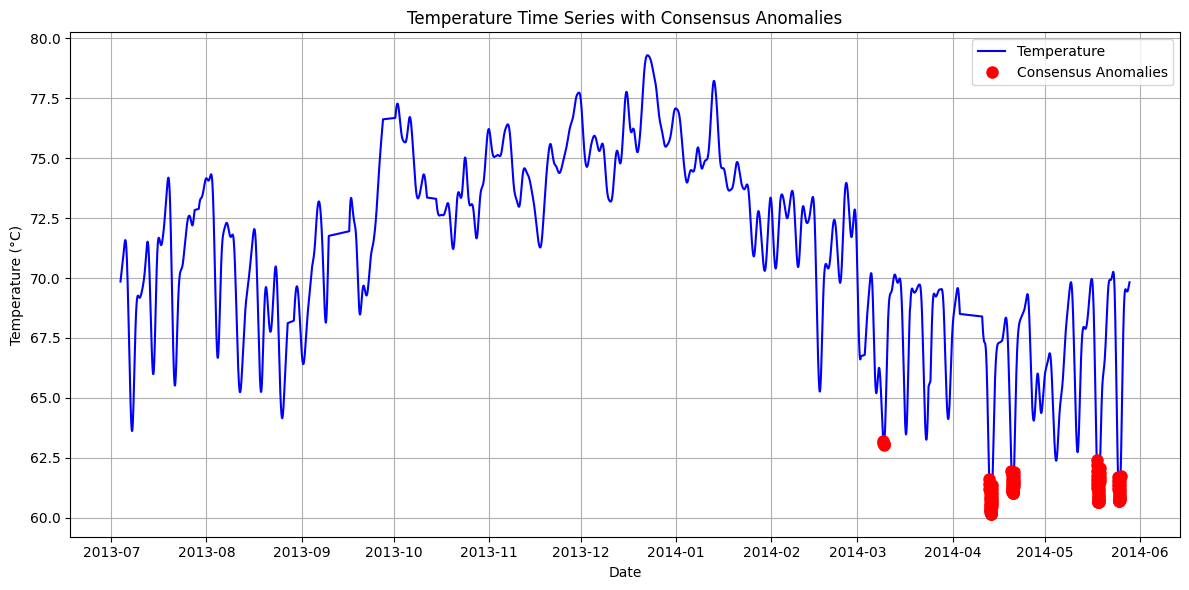

Total points analyzed: 7267
Z-score anomalies: 0
FFT-based anomalies: 87
Isolation Forest anomalies: 362


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import zscore

# Assuming you have your temperature data in df with a datetime index
# and 'value_lowpass' as your filtered temperature column

# Method 1: Statistical approach - Z-score based anomaly detection
def detect_anomalies_zscore(data, threshold=3):
    """Detect anomalies using Z-score method."""
    z_scores = zscore(data)
    return np.abs(z_scores) > threshold

# Method 2: FFT-based reconstruction and residual analysis
def detect_anomalies_fft(data, num_components=10, threshold=2.5):
    """Detect anomalies by comparing original signal with FFT reconstruction."""
    # Compute FFT
    fft_values = np.fft.rfft(data)
    # Sort frequencies by magnitude
    frequencies = np.fft.rfftfreq(len(data))
    magnitudes = np.abs(fft_values)
    # Get indices of top frequencies
    top_indices = np.argsort(magnitudes)[::-1][:num_components]
    # Keep only the top components
    filtered_fft = np.zeros_like(fft_values, dtype=complex)
    filtered_fft[top_indices] = fft_values[top_indices]
    # Reconstruct signal
    reconstructed = np.fft.irfft(filtered_fft, n=len(data))
    # Calculate residuals
    residuals = data - reconstructed
    # Detect anomalies in residuals
    residual_mean = np.mean(residuals)
    residual_std = np.std(residuals)
    return np.abs(residuals - residual_mean) > threshold * residual_std, reconstructed, residuals

# Method 3: Isolation Forest (machine learning approach)
def detect_anomalies_iforest(data, contamination=0.05):
    """Detect anomalies using Isolation Forest."""
    # Reshape data for sklearn
    reshaped_data = data.reshape(-1, 1)
    # Create and fit model
    model = IsolationForest(contamination=contamination, random_state=42)
    model.fit(reshaped_data)
    # Predict anomalies
    predictions = model.predict(reshaped_data)
    # -1 for anomalies, 1 for normal points
    return predictions == -1

# Method 4: Seasonal decomposition and residual analysis
def detect_anomalies_seasonal(data, index, period=None, threshold=2.5):
    """Detect anomalies using seasonal decomposition."""
    # Create Series with datetime index
    ts = pd.Series(data, index=index)

    # If period is not specified, try to estimate from FFT results
    if period is None:
        fft_values = np.fft.rfft(data)
        frequencies = np.fft.rfftfreq(len(data))
        magnitudes = np.abs(fft_values)
        # Get index of maximum magnitude (excluding DC component)
        max_idx = np.argmax(magnitudes[1:]) + 1
        period = int(1 / frequencies[max_idx])
        print(f"Estimated period from FFT: {period}")

    # Apply seasonal decomposition
    decomposition = seasonal_decompose(ts, period=period, extrapolate_trend='freq')
    residuals = decomposition.resid

    # Detect anomalies in residuals
    residual_mean = residuals.mean()
    residual_std = residuals.std()
    anomalies = np.abs(residuals - residual_mean) > threshold * residual_std

    return anomalies, decomposition

# Apply the detection methods to your data
temp_data = df['value_lowpass'].values
dates = df.index

# Use the fundamental period we detected before (~303 days)
fundamental_period = 303

# 1. Z-score method
zscore_anomalies = detect_anomalies_zscore(temp_data, threshold=3)

# 2. FFT-based method
fft_anomalies, reconstructed, residuals = detect_anomalies_fft(
    temp_data, num_components=6, threshold=2.5)

# 3. Isolation Forest
iforest_anomalies = detect_anomalies_iforest(temp_data, contamination=0.05)

# 4. Seasonal decomposition
# Use an approximate value for the period
period_approx = int(round(fundamental_period))
seasonal_anomalies, decomposition = detect_anomalies_seasonal(
    temp_data, dates, period=period_approx, threshold=2.5)

# Visualization of anomalies detected by each method
plt.figure(figsize=(14, 10))

# Original data with Z-score anomalies
plt.subplot(4, 1, 1)
plt.plot(dates, temp_data, 'b-', label='Temperature')
plt.plot(dates[zscore_anomalies], temp_data[zscore_anomalies], 'ro', label='Z-score Anomalies')
plt.title('Z-score Based Anomaly Detection')
plt.legend()
plt.grid(True)

# FFT reconstruction and anomalies
plt.subplot(4, 1, 2)
plt.plot(dates, temp_data, 'b-', alpha=0.6, label='Original')
plt.plot(dates, reconstructed, 'g-', alpha=0.8, label='FFT Reconstruction')
plt.plot(dates[fft_anomalies], temp_data[fft_anomalies], 'ro', label='FFT Anomalies')
plt.title('FFT-based Reconstruction and Anomaly Detection')
plt.legend()
plt.grid(True)

# Isolation Forest anomalies
plt.subplot(4, 1, 3)
plt.plot(dates, temp_data, 'b-', label='Temperature')
plt.plot(dates[iforest_anomalies], temp_data[iforest_anomalies], 'ro', label='Isolation Forest Anomalies')
plt.title('Isolation Forest Anomaly Detection')
plt.legend()
plt.grid(True)

# Seasonal decomposition anomalies
plt.subplot(4, 1, 4)
plt.plot(dates, temp_data, 'b-', label='Temperature')
plt.plot(dates[seasonal_anomalies], temp_data[seasonal_anomalies], 'ro', label='Seasonal Anomalies')
plt.title(f'Seasonal Decomposition Anomaly Detection (Period={period_approx})')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Compare the anomalies detected by different methods
combined_anomalies = pd.DataFrame({
    'Z-score': zscore_anomalies,
    'FFT': fft_anomalies,
    'Isolation Forest': iforest_anomalies,
    'Seasonal': seasonal_anomalies
}, index=dates)

# Count how many methods detected each point as an anomaly
agreement_count = combined_anomalies.sum(axis=1)

# Points flagged by multiple methods are more likely to be true anomalies
consensus_anomalies = agreement_count >= 2  # At least 2 methods agree

# Final visualization with consensus anomalies
plt.figure(figsize=(12, 6))
plt.plot(dates, temp_data, 'b-', label='Temperature')
plt.plot(dates[consensus_anomalies], temp_data[consensus_anomalies],
         'ro', markersize=8, label='Consensus Anomalies')
plt.title('Temperature Time Series with Consensus Anomalies')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary of anomalies
print(f"Total points analyzed: {len(temp_data)}")
print(f"Z-score anomalies: {sum(zscore_anomalies)}")
print(f"FFT-based anomalies: {sum(fft_anomalies)}")
print(f"Isolation Forest anomalies: {sum(iforest_anomalies)}")
print

Testing normal temperature values:
--------------------------------
Date: 2014-06-27, Value: 69.5°C, Anomaly: False
  Z-score: 0.44, Seasonal Z: 0.39, Model score: -0.15

Date: 2014-07-27, Value: 71.2°C, Anomaly: False
  Z-score: 0.01, Seasonal Z: 0.02, Model score: -0.13

Date: 2014-08-26, Value: 74.8°C, Anomaly: False
  Z-score: 0.91, Seasonal Z: 2.78, Model score: -0.15

Date: 2014-09-25, Value: 68.9°C, Anomaly: False
  Z-score: 0.60, Seasonal Z: 1.64, Model score: -0.11

Date: 2014-10-25, Value: 72.3°C, Anomaly: False
  Z-score: 0.27, Seasonal Z: 1.18, Model score: -0.14


Testing potentially anomalous temperature values:
--------------------------------------------
Date: 2014-06-27, Value: 85.7°C, Anomaly: True
  Z-score: 3.70, Seasonal Z: 7.32, Model score: 0.12

Date: 2014-07-27, Value: 60.1°C, Anomaly: True
  Z-score: 2.85, Seasonal Z: 4.85, Model score: 0.16

Date: 2014-08-26, Value: 79.9°C, Anomaly: True
  Z-score: 2.22, Seasonal Z: 5.12, Model score: 0.12

Date: 2014-09-25, 

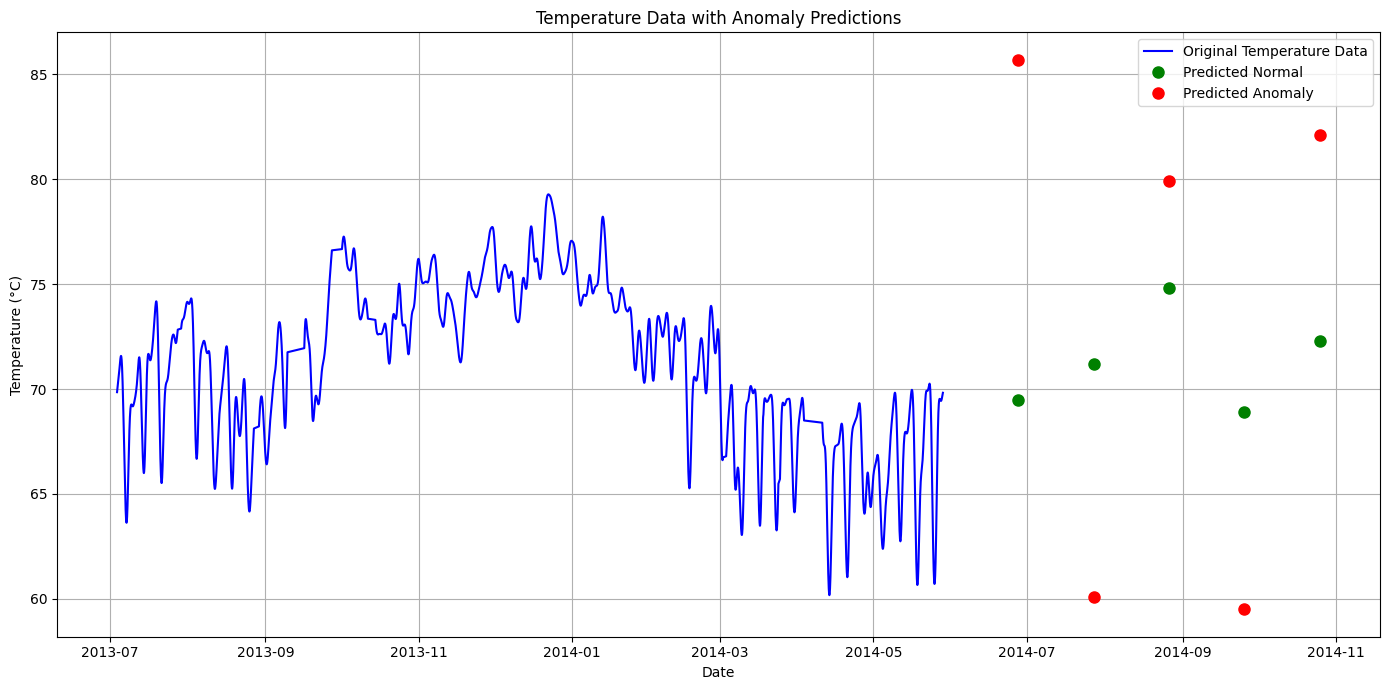

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from scipy import signal

# Assuming we have already performed the FFT analysis and anomaly detection
# on the original temperature data stored in df['value_lowpass']

# Let's create a function that combines multiple methods to predict anomalies
def predict_anomaly(new_value, date, model, original_data, dates, fundamental_period=303):
    """
    Predict if a new temperature value is an anomaly using multiple methods.

    Parameters:
    -----------
    new_value : float
        The new temperature value to check
    date : datetime
        The date of the new measurement
    model : trained model
        Pre-trained Isolation Forest model
    original_data : array
        Original temperature data used for training
    dates : array
        Original dates corresponding to the temperature data
    fundamental_period : int
        The fundamental period detected in the data

    Returns:
    --------
    is_anomaly : bool
        True if the value is predicted to be an anomaly
    scores : dict
        Dictionary with individual anomaly scores from each method
    """
    scores = {}

    # 1. Z-score method
    z_score = (new_value - np.mean(original_data)) / np.std(original_data)
    scores['z_score'] = abs(z_score)
    z_anomaly = abs(z_score) > 3

    # 2. Context-based method - compare with values from similar season
    # Find days in similar season from previous years
    days_in_year = 365.25
    seasonal_matches = []
    for i, d in enumerate(dates):
        # Check if date is within +/- 15 days of the same day in other years
        days_diff = abs((date - d).days % days_in_year)
        if days_diff < 15 or days_diff > (days_in_year - 15):
            seasonal_matches.append(i)

    if seasonal_matches:
        seasonal_values = original_data[seasonal_matches]
        seasonal_mean = np.mean(seasonal_values)
        seasonal_std = np.std(seasonal_values)
        seasonal_z = (new_value - seasonal_mean) / max(seasonal_std, 0.1)  # Avoid div by zero
        scores['seasonal_z'] = abs(seasonal_z)
        seasonal_anomaly = abs(seasonal_z) > 2.5
    else:
        seasonal_anomaly = False
        scores['seasonal_z'] = 0

    # 3. Model-based method (Isolation Forest)
    model_score = model.decision_function([[new_value]])
    scores['model_score'] = -model_score[0]  # Negated so higher = more anomalous
    model_anomaly = model.predict([[new_value]])[0] == -1

    # Combine methods (majority vote)
    anomaly_votes = sum([z_anomaly, seasonal_anomaly, model_anomaly])
    is_anomaly = anomaly_votes >= 2  # At least 2 methods agree

    return is_anomaly, scores

# Let's train the model using the original data
temp_data = df['value_lowpass'].values.reshape(-1, 1)
model = IsolationForest(contamination=0.05, random_state=42)
model.fit(temp_data)

# Let's create some example values to test
# Assume the last date in our dataset
last_date = df.index[-1]

# Normal example dates (one month after the end of our dataset)
test_dates = [
    last_date + pd.Timedelta(days=30),
    last_date + pd.Timedelta(days=60),
    last_date + pd.Timedelta(days=90),
    last_date + pd.Timedelta(days=120),
    last_date + pd.Timedelta(days=150)
]

# Examples of normal temperature values (based on seasonal patterns)
normal_values = [69.5, 71.2, 74.8, 68.9, 72.3]

# Examples of potentially anomalous temperature values
anomalous_values = [85.7, 60.1, 79.9, 59.5, 82.1]

# Test the examples
print("Testing normal temperature values:")
print("--------------------------------")
for date, value in zip(test_dates, normal_values):
    is_anomaly, scores = predict_anomaly(value, date, model, df['value_lowpass'].values, df.index)
    print(f"Date: {date.strftime('%Y-%m-%d')}, Value: {value:.1f}°C, Anomaly: {is_anomaly}")
    print(f"  Z-score: {scores['z_score']:.2f}, Seasonal Z: {scores['seasonal_z']:.2f}, Model score: {scores['model_score']:.2f}")
    print()

print("\nTesting potentially anomalous temperature values:")
print("--------------------------------------------")
for date, value in zip(test_dates, anomalous_values):
    is_anomaly, scores = predict_anomaly(value, date, model, df['value_lowpass'].values, df.index)
    print(f"Date: {date.strftime('%Y-%m-%d')}, Value: {value:.1f}°C, Anomaly: {is_anomaly}")
    print(f"  Z-score: {scores['z_score']:.2f}, Seasonal Z: {scores['seasonal_z']:.2f}, Model score: {scores['model_score']:.2f}")
    print()

# Visualize the original data with our test points
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['value_lowpass'], 'b-', label='Original Temperature Data')

# Plot normal test values
for date, value in zip(test_dates, normal_values):
    is_anomaly, _ = predict_anomaly(value, date, model, df['value_lowpass'].values, df.index)
    if is_anomaly:
        plt.plot(date, value, 'ro', markersize=8, label='Predicted Anomaly' if 'Predicted Anomaly' not in plt.gca().get_legend_handles_labels()[1] else "")
    else:
        plt.plot(date, value, 'go', markersize=8, label='Predicted Normal' if 'Predicted Normal' not in plt.gca().get_legend_handles_labels()[1] else "")

# Plot anomalous test values
for date, value in zip(test_dates, anomalous_values):
    is_anomaly, _ = predict_anomaly(value, date, model, df['value_lowpass'].values, df.index)
    if is_anomaly:
        plt.plot(date, value, 'ro', markersize=8, label='Predicted Anomaly' if 'Predicted Anomaly' not in plt.gca().get_legend_handles_labels()[1] else "")
    else:
        plt.plot(date, value, 'go', markersize=8, label='Predicted Normal' if 'Predicted Normal' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.title('Temperature Data with Anomaly Predictions')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

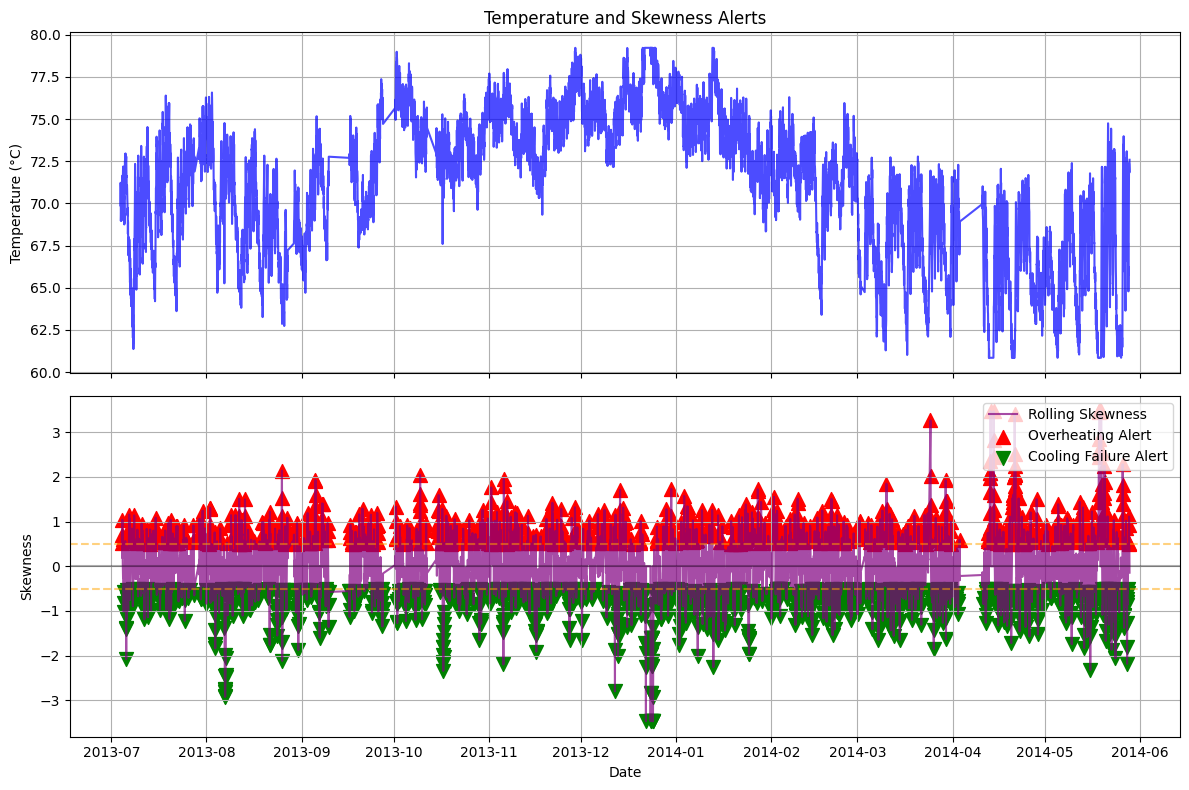

In [ ]:
import matplotlib.pyplot as plt

# Calculate rolling skewness (e.g., 12-hour window)
df['rolling_skew'] = df['value_truncated'].rolling(window=12).skew()

# Define skew alerts based on thresholds
df['skew_alert'] = 0
df.loc[df['rolling_skew'] > 0.5, 'skew_alert'] = 1
df.loc[df['rolling_skew'] < -0.5, 'skew_alert'] = -1

# Identify alert points
overheat = df[df['skew_alert'] == 1]
cooling_fail = df[df['skew_alert'] == -1]

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 1. Plot Temperature (top subplot)
ax1.plot(df.index, df['value_truncated'], label='Temperature', color='blue', alpha=0.7)
ax1.set_ylabel('Temperature (°C)')
ax1.set_title('Temperature and Skewness Alerts')
ax1.grid(True)

# 2. Plot Rolling Skewness (bottom subplot)
ax2.plot(df.index, df['rolling_skew'], label='Rolling Skewness', color='purple', alpha=0.7)

# 3. Add Skewness Alerts as Triangles
ax2.scatter(overheat.index, overheat['rolling_skew'],
            marker='^', color='red', s=100, label='Overheating Alert')
ax2.scatter(cooling_fail.index, cooling_fail['rolling_skew'],
            marker='v', color='green', s=100, label='Cooling Failure Alert')

# Threshold lines
ax2.axhline(0.5, linestyle='--', color='orange', alpha=0.5)
ax2.axhline(-0.5, linestyle='--', color='orange', alpha=0.5)
ax2.axhline(0, linestyle='-', color='black', alpha=0.3)

ax2.set_ylabel('Skewness')
ax2.set_xlabel('Date')
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from joblib import dump

# Save the anomaly detection model
dump(model, 'anomaly_model.joblib')

# Save the temperature stats you need
dump({'mean': np.mean(df['value_lowpass']),
     'std': np.std(df['value_lowpass'])},
     'temp_stats.joblib')

['temp_stats.joblib']

In [ ]:
import pandas as pd
import numpy as np

# Load your data
df = pd.read_csv('/content/ambient_temperature_system_failure.csv', parse_dates=['timestamp'])
df = df.set_index('timestamp').sort_index()

# Create rolling statistics for anomaly detection
window_size = 24  # 24-hour window
df['rolling_mean'] = df['value'].rolling(window=window_size).mean()
df['rolling_std'] = df['value'].rolling(window=window_size).std()

# Label anomalies (z-score > 3)
df['z_score'] = (df['value'] - df['rolling_mean']) / df['rolling_std']
df['anomaly'] = np.abs(df['z_score']) > 3

# Create failure labels (1 = failure period, 0 = normal)
# Here we assume failures occur during/after anomalies
df['failure'] = 0
failure_buffer = 6  # 6 hours before/after anomaly counts as failure period

for i in range(len(df)):
    if df['anomaly'].iloc[i]:
        start = max(0, i - failure_buffer)
        end = min(len(df), i + failure_buffer)
        df.iloc[start:end, df.columns.get_loc('failure')] = 1

# Forward-fill failure labels (to predict impending failures)
df['failure_label'] = df['failure'].shift(-failure_buffer).fillna(0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['value']])

# Parameters
look_back = 72  # Look back 72 hours (3 days)
batch_size = 32

# Create time series generator
train_gen = TimeseriesGenerator(
    data=scaled_data,
    targets=df['failure_label'].values,
    length=look_back,
    batch_size=batch_size
)

# Split into train/validation
n_samples = len(train_gen)
train_samples = int(0.8 * n_samples)

train_data = []
train_targets = []
for i in range(train_samples):
    x, y = train_gen[i]
    train_data.append(x)
    train_targets.append(y)

val_data = []
val_targets = []
for i in range(train_samples, n_samples):
    x, y = train_gen[i]
    val_data.append(x)
    val_targets.append(y)

train_data = np.concatenate(train_data)
train_targets = np.concatenate(train_targets)
val_data = np.concatenate(val_data)
val_targets = np.concatenate(val_targets)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(64, input_shape=(look_back, 1)),  # 64 LSTM units - Added missing parenthesis
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data, train_targets,
    epochs=50,
    batch_size=batch_size,
    validation_data=(val_data, val_targets),
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.9229 - loss: 0.2529 - precision: 0.0148 - recall: 0.0598 - val_accuracy: 0.9547 - val_loss: 0.2036 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9831 - loss: 0.0875 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9547 - val_loss: 0.1952 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9779 - loss: 0.1076 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9547 - val_loss: 0.2222 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9784 - loss: 0.1055 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9547 - val_loss: 0.1925 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9844 - loss: 0.0822 - precision